In [21]:
from pystac_client import Client
import geopandas as gpd
from datetime import datetime, UTC
import stackstac
import xarray as xr
from shapely.geometry import Point
from rasterio.errors import RasterioIOError
from planetary_computer import sign_inplace
import matplotlib.pyplot as plt
import sentinel2indices as s2i
from skimage.exposure import match_histograms
import math

<Axes: >

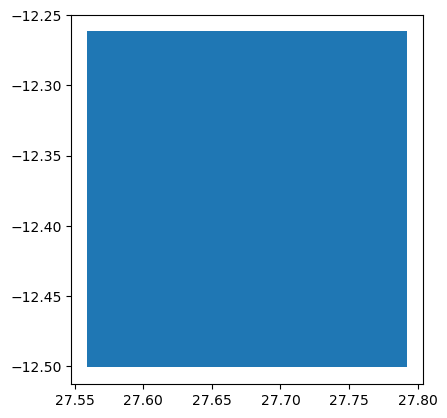

In [4]:
# Connect to Planetary Computer STAC
stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Load AOI from GeoJSON file
aoi_path = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\Archive\KoboldData\zambia_aoi_small.geojson"
aoi_gdf = gpd.read_file(aoi_path)

# Reproject to WGS84 if needed
if aoi_gdf.crs != "EPSG:4326":
    aoi_gdf = aoi_gdf.to_crs("EPSG:4326")

aoi_gdf.plot()

In [5]:
# Search STAC for low-cloud Sentinel-2 L2A items over AOI

# Broad date range — Sentinel-2 L2A available since mid-2017
start_date = "2017-06-28"
end_date = datetime.now(UTC).date().isoformat()

# Query STAC for clean Sentinel-2 L2A items
search = stac.search(
    collections=["sentinel-2-l2a"],
    intersects=aoi_gdf.geometry[0].__geo_interface__,
    datetime=f"{start_date}/{end_date}",
    query={"eo:cloud_cover": {"lt": 10}},  # low-cloud only
    sortby=["eo:cloud_cover"],  # sort by best quality
)

items = list(search.items())
print(f"Found {len(items)} items")

# Print out all property keys on the first item to view available metadata
props = items[0].properties
for k in sorted(props):
    print(k)

Found 300 items
constellation
datetime
eo:cloud_cover
instruments
platform
proj:code
s2:cloud_shadow_percentage
s2:datastrip_id
s2:datatake_id
s2:datatake_type
s2:degraded_msi_data_percentage
s2:generation_time
s2:granule_id
s2:high_proba_clouds_percentage
s2:mean_solar_azimuth
s2:mean_solar_zenith
s2:medium_proba_clouds_percentage
s2:mgrs_tile
s2:nodata_pixel_percentage
s2:not_vegetated_percentage
s2:processing_baseline
s2:product_type
s2:product_uri
s2:reflectance_conversion_factor
s2:saturated_defective_pixel_percentage
s2:snow_ice_percentage
s2:thin_cirrus_percentage
s2:unclassified_percentage
s2:vegetation_percentage
s2:water_percentage
sat:orbit_state
sat:relative_orbit


In [14]:
# Filter for S2A scenes, set EPSG, and stack selected bands at 10m resolution

# Keep only S2A scenes (from all items) and sign their URLs
s2a_items = [it for it in items if it.id.startswith("S2A")][:20]
if not s2a_items:
    raise RuntimeError("No S2A scenes found—check your STAC search criteria.")
for it in s2a_items:
    sign_inplace(it)
print("Using these S2A items:", [it.id for it in s2a_items])

# Try EPSG from first item
item0 = s2a_items[0]
epsg = None
try:
    epsg = item0.assets["B02"].extra_fields["proj:epsg"]
    print(f"Using EPSG from first item: {epsg}")
except KeyError:
    pass

# Fall back to AOI centroid
if epsg is None:
    centroid: Point = aoi_gdf.geometry[0].centroid
    lon, lat = centroid.x, centroid.y
    zone = int((lon + 180) / 6) + 1
    epsg = 32600 + zone if lat >= 0 else 32700 + zone
    print(f"Using EPSG from AOI centroid: {epsg}")

# Stack normally, resolution=10m for all bands
stack = stackstac.stack(
    s2a_items,
    assets=["B01", "B02", "B03", "B04", "B08", "B8A", "B11", "B12", "SCL"],
    resolution=10,  # 10m resolution for all bands
    epsg=epsg,
    chunksize=2048,
    bounds_latlon=aoi_gdf.total_bounds,
    dtype="float64",
    rescale=True,
    errors_as_nodata=[RasterioIOError, RuntimeError],
)

stack

Using these S2A items: ['S2A_MSIL2A_20241008T080831_R078_T35LNG_20241008T121151', 'S2A_MSIL2A_20240908T080611_R078_T35LNG_20240908T142348', 'S2A_MSIL2A_20240829T080601_R078_T35LNG_20240829T125422', 'S2A_MSIL2A_20240819T080611_R078_T35LNG_20240819T130750', 'S2A_MSIL2A_20240809T080611_R078_T35LNG_20240809T145755', 'S2A_MSIL2A_20240720T080611_R078_T35LNG_20240720T133231', 'S2A_MSIL2A_20240710T080611_R078_T35LNG_20240710T151222', 'S2A_MSIL2A_20240630T080611_R078_T35LNG_20240701T190652', 'S2A_MSIL2A_20240620T080611_R078_T35LNG_20240620T140208', 'S2A_MSIL2A_20240531T080611_R078_T35LNG_20240531T150458', 'S2A_MSIL2A_20230924T080651_R078_T35LNG_20230924T141335', 'S2A_MSIL2A_20230904T080611_R078_T35LNG_20241104T133156', 'S2A_MSIL2A_20230904T080611_R078_T35LNG_20230904T173507', 'S2A_MSIL2A_20230825T080611_R078_T35LNG_20241026T184312', 'S2A_MSIL2A_20230825T080611_R078_T35LNG_20230825T162213', 'S2A_MSIL2A_20230815T080611_R078_T35LNG_20230815T171601', 'S2A_MSIL2A_20230805T080611_R078_T35LNG_20241026

<xarray.DataArray 'stackstac-00430f2622b467e4f268dabac49ce045' (time: 20,
                                                                band: 9,
                                                                y: 2655, x: 2545)> Size: 10GB
dask.array<fetch_raster_window, shape=(20, 9, 2655, 2545), dtype=float64, chunksize=(1, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 160B 2023-...
    id                                       (time) <U54 4kB 'S2A_MSIL2A_2023...
  * band                                     (band) <U3 108B 'B01' ... 'SCL'
  * x                                        (x) float64 20kB 5.607e+05 ... 5...
  * y                                        (y) float64 21kB 8.644e+06 ... 8...
    s2:datatake_id                           (time) <U34 3kB 'GS2A_20230716T0...
    ...                                       ...
    gsd                                      (band) float64 72B 60.0 ... 20.0
    proj:bbox                                object 8B {8590240.0, 8700040.0,...
    common_name                              (band) object 72B 'coastal' ... ...
    center_wavelength                        (band) object 72B 0.443 ... None
    full_width_half_max                      (band) object 72B 0.027 ... None
    epsg                                     int64 8B 32735
Attributes:
    spec:        RasterSpec(epsg=32735, bounds=(560740, 8617920, 586190, 8644...
    crs:         epsg:32735
    transform:   | 10.00, 0.00, 560740.00|\n| 0.00,-10.00, 8644470.00|\n| 0.0...
    resolution:  10

In [18]:
# Histogram‐match with dask_gufunc_kwargs

# Rechunk so band, y, x are single chunks
stack_small = stack.chunk({"band": -1, "y": -1, "x": -1})

# Reference = first clean scene (no time dim)
# 2. pick all the reflectance bands (no SCL)
ref_bands = ["B01", "B02", "B03", "B04", "B08", "B8A", "B11", "B12"]
ref = stack_small.isel(time=0).sel(band=ref_bands).chunk({"band": -1, "y": -1, "x": -1})


def match_to_ref(scene, ref):
    return xr.apply_ufunc(
        match_histograms,
        scene,
        ref,
        input_core_dims=[["band", "y", "x"], ["band", "y", "x"]],
        output_core_dims=[["band", "y", "x"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[scene.dtype],
        dask_gufunc_kwargs={
            "allow_rechunk": True,
            "output_sizes": {
                "band": scene.sizes["band"],
                "y": scene.sizes["y"],
                "x": scene.sizes["x"],
            },
        },
    )


# Build the normalized stack, re-adding time
matched = []
for i, t in enumerate(stack_small.time.values):
    scene = stack_small.isel(time=i).sel(band=ref.band)
    scene = scene.chunk({"band": -1, "y": -1, "x": -1})
    m = match_to_ref(scene, ref)
    m = m.expand_dims(time=[t])
    matched.append(m)


stack_norm = xr.concat(matched, dim="time")

In [19]:
# Mask invalid pixels using SCL and compute median composite over time


# Ensure your original stack is rechunked so SCL aligns
stack_small = stack.chunk({"band": -1, "y": -1, "x": -1})

# Extract the Scene Classification Layer and build a “valid” mask
scl = stack_small.sel(band="SCL")
valid = scl.isin([4, 5, 6])  # vegetation=4, bare soil=5, water=6

# Apply mask to the histogram-matched reflectance and composite

clean = stack_norm.where(valid)       # holds only the reflectance bands (no SCL)
composite = clean.median(dim="time")

# Inspect the composite
composite

<xarray.DataArray 'stackstac-00430f2622b467e4f268dabac49ce045' (band: 8,
                                                                y: 2655, x: 2545)> Size: 432MB
dask.array<nanmedian, shape=(8, 2655, 2545), dtype=float64, chunksize=(1, 935, 896), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                                     (band) <U3 96B 'B01' ... 'B12'
  * x                                        (x) float64 20kB 5.607e+05 ... 5...
  * y                                        (y) float64 21kB 8.644e+06 ... 8...
    constellation                            <U10 40B 'Sentinel 2'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    sat:relative_orbit                       int64 8B 78
    ...                                       ...
    instruments                              <U3 12B 'msi'
    platform                                 <U11 44B 'Sentinel-2A'
    sat:orbit_state                          <U10 40B 'descending'
    s2:product_type                          <U7 28B 'S2MSI2A'
    proj:bbox                                object 8B {8590240.0, 8700040.0,...
    epsg                                     int64 8B 32735

In [ ]:
# Plot the indices

# list out each function you want to try
funcs = [
    s2i.alterations_s2,
    s2i.fe_silicates_s2,
    s2i.fe2o3_s2,
    s2i.fe3_s2,
    s2i.goethite_s2,
    s2i.calcite_emit,
    s2i.clay_minerals_emit,
    s2i.epi_chlo_calc_emit,
    s2i.feai_emit,
    s2i.fei_emit,
    s2i.gypsum_emit,
    s2i.illite_emit,
    s2i.iron_oxides_emit,
    s2i.kaolinite1_emit,
    s2i.kaolinite3_emit,
    s2i.montmorillonite_emit,
]

results = []
for fn in funcs:
    try:
        da = fn(composite)
        results.append(da)
    except NotImplementedError as e:
        print(f"⚠️ {e}")

# combine any that did return a DataArray
if results:
    indices = xr.concat(results, dim="band")
    indices["band"] = [da.name for da in results]
    display(indices)
else:
    print("No indices computed.")


⚠️ Alterations S2 formula not found in public sources.
⚠️ Fe3+ S2 formula not found in public sources.
⚠️ Calcite EMIT index formula not found.
⚠️ Clay Minerals EMIT index formula not found.
⚠️ EPI/CHLO/CALC EMIT index formula not found.
⚠️ FEAI EMIT index formula not found.
⚠️ FEI EMIT index formula not found.
⚠️ Gypsum EMIT index formula not found.
⚠️ Illite EMIT index formula not found.
⚠️ Iron Oxides EMIT index formula not found.
⚠️ Kaolinite 1 EMIT index formula not found.
⚠️ Kaolinite 3 EMIT index formula not found.
⚠️ Montmorillonite EMIT index formula not found.


<xarray.DataArray 'stackstac-00430f2622b467e4f268dabac49ce045' (band: 3,
                                                                y: 2655, x: 2545)> Size: 162MB
dask.array<concatenate, shape=(3, 2655, 2545), dtype=float64, chunksize=(1, 935, 896), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * x                                        (x) float64 20kB 5.607e+05 ... 5...
  * y                                        (y) float64 21kB 8.644e+06 ... 8...
    constellation                            <U10 40B 'Sentinel 2'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    sat:relative_orbit                       int64 8B 78
    s2:snow_ice_percentage                   float64 8B 0.0
    ...                                       ...
    platform                                 <U11 44B 'Sentinel-2A'
    sat:orbit_state                          <U10 40B 'descending'
    s2:product_type                          <U7 28B 'S2MSI2A'
    proj:bbox                                object 8B {8590240.0, 8700040.0,...
    epsg                                     int64 8B 32735
  * band                                     (band) <U42 504B 'stackstac-0043...

In [ ]:
# Plot all computed indices in a grid of subplots

import matplotlib.pyplot as plt
import math

# Pre‐compute each index into memory (2D DataArrays)
computed = {band: indices.sel(band=band).compute() for band in indices.band.values}

n = len(computed)
ncols = min(4, n)
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

for i, (band, da) in enumerate(computed.items()):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    # choose a colormap per index name
    name = band.lower()
    if "clay" in name:
        cmap = "terrain"
    elif "iron" in name:
        cmap = "RdBu"
    else:
        cmap = "viridis"

    # plot the 2D array with its own colorbar
    im = da.plot(
        ax=ax,
        cmap=cmap,
        add_colorbar=False,
    )
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label(band.replace("_", " ").title())
    ax.set_title(band.replace("_", " ").title())
    ax.axis("off")

# turn off any leftover empty subplots
for j in range(n, nrows * ncols):
    r, c = divmod(j, ncols)
    axes[r][c].axis("off")

plt.tight_layout()
plt.show()

-------------------

In [ ]:
# Compute clay and iron oxide indices from composite bands

# Select bands
b04 = composite.sel(band="B04")
b11 = composite.sel(band="B11")
b12 = composite.sel(band="B12")

# Compute indices
clay_index = (b12 / b11).rename("clay_index")
iron_index = ((b04 - b11) / (b04 + b11)).rename("iron_index")

# Combine into one DataArray
indices = xr.concat([clay_index, iron_index], dim="band")
indices["band"] = ["clay_index", "iron_index"]

# Inspect
indices

In [ ]:
# Load clay and iron index arrays fully into memory for plotting

clay = indices.sel(band="clay_index").compute()
iron = indices.sel(band="iron_index").compute()

In [ ]:
# Plot the clay index
clay.plot(
    cmap="terrain",
    cbar_kwargs={"label": "Clay Index"},
)
plt.title("Clay Index")
plt.axis("off")


In [ ]:
# Plot the iron oxide index
iron.plot(
    cmap="RdBu",
    cbar_kwargs={"label": "Iron Oxide Index"},
)
plt.title("Iron Oxide Index")
plt.axis("off")